# PUI2015 FINAL EXAM

#### Dan Quasney

##### Posted to GitHub with express permission from Dr. Bianco (@fedhere)

## This exam is take home. Deliver your solution as an ipython notebook, uploading it to NYUclasses BY TUESDAY 12/22/2016 at 11:59:59 PM 
## work alone. If you have questions, feel free to ask your instructors and TAs. High level intellectual discussion is never forbidden, so general, conceptual questions can be discussed with your classmates, but do not exchange code, or algorithms (specific solution design).

example of a fair question: Do you think clustering if all my variables are spatial requires whitening?

example of an unfair question: did you divide the longitude by its mean or subtract it?



# Goal: evaluate the relevance of different factors in causing asthma in NYC. 


## Motivation: 
Several environmental variables affect respiratory health. The health department finds correlation between asthma cases and a number of geographical factors, including:
proximity to highways, proximity to green spaces, criminality rate (murder rate specifically). Additionally environmental factors such as construction releasing air pollutants, unsanitary conditions, etc., may trigger respiratory problems.
In this work you will attempt to valuate the importance of these factors.


## Method: 

work on the ZIP code level.

1) __Identify the 5 facilities__ that reported the highest incidence of asthma cases and find which ZIP code they fall in.

2) __Develop a Metric__ for each of the fllowing: access to green space, murder rate, environmental health, and proximity to highways for each ZIP code (no panic, suggestions on how to proceed are in the hints file). You must choose AT LEAST 2 variables among these 4. We encourage you to work with three. Choosing 4 or more, and coming up with additional ones, is considered extra credit.

3) __Show a table__ containing the value of each variable of interest for the 5 ZIP codes corresponding to the highest cases of Asthma.

4) __Display__ each of your metrics as a choropleth (a heatmap version of a geographical map where each zip code is a different color based on the value of the metric you are mapping).

5) __Fit__ a model  (try a multivariate linear model for example or any other model which you think may be reasonable, keeping in mind you will need to use the model in the last task) to the incidence of asthma cases per NYC ZIP code (this is your dependent variable) as a function of variables mentioned above, based on the ZIP codes of the top 5 facilities reporing asthma. 

6) __Cluster__ the ZIP codes using the model you generated in step 4 as a distance metric (suggestions if needed are in the hints file).

7) __Discuss__. What did you find? What is the spatial coherence of the different factors considered, which variables seem to be more important in triggering asthma cases, what are the weaknesses of the model, how does the clustering look. 




# DATA: 
## the data is described in the PUI2015_DATA.ipynb markdown

# HINTS:
## The first hint is to READ THROUGH ALL OF THE INSTRUCTIONS. There are several tasks, but don't get overwhelmed:  these are all things you have done before, and for which you have examples in the codes from the lecture and in the homework!

## Get all the data you will need before you go into data munging.

## Complete the mimum requirements first. Then go back and work on optional requirements, and continue improving your work as much as you can from there, in a modular way (so you know you have the minimum by the deadline at least!)

## Several more detailed hints are given in the PUI2015_HINTS.ipynb markdown

# RULES:
## rules are spelled out in the PUI2015_RULES.ipynb markdown    
## Dont cheat. Cheating will be punished with at least failing the class, and reported to the educational team for consideration of more significant action.

In [1]:
# import modules we might need
import pandas as pd
from shapely.geometry import Point
import numpy as np
import zipfile 
import pandas as pd
from pandas import DataFrame
import glob
import json
import pylab as pl
import sklearn.cluster
import os
import scipy
import geopandas as gp
from geopandas import GeoDataFrame
import statsmodels.formula.api as smf
import ast
import json
import sklearn
import urllib
import urllib2
from cStringIO import StringIO
import pandas as pd
import geopandas as gp
from geopandas import GeoDataFrame
from geopandas import GeoSeries
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# use colors from homework 10
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]


<h1> Task 1: Querying Asthma Discharges </h1>

In this first task, you are to asked to retrieve the top 5 facility IDs that had the highest count of asthma treatments in 2013. We can assume that any case that is diagnosed as an Asthma treatment should have the word "*asthma*" (case-insensitive) in the **ccs_diagnosis_description** of the **nyc_discharge_2013**. This must be done through a SQL command.
In the data section we define a helper function <b>queryCartoDB</b> to wrap around the SQL API of CartoDB. We can simply pass in a public data source (in the form of 'https://{ACCOUNT}.cartodb.com/api/v2/sql', where ACCOUNT is the owner of the data) and a SQL statement for us to query the data in various formats including CSV, JSON, and GeoJSON. There will be three data sources (with table name in parentheses) to be queried from the CartoDB databases: so that you canget data for the New York City Hospital Inpatient 2013 Discharge, Health Facility Information, Highway streets per zip code.

Examples and bits of code you can use are provided in the PUI2015_DATA.ipynb (you can copy an paste code from there into this notebook)

After retrieveing those 5 IDs, please cross-reference them with the IDs listed in the **nyc_facility** table (this could be done with SQL or offline with GeoPandas using the **facilities** variable above). Then provide us with the following:

<ol>
<li>The list the top 5 facilities by their facility names (aka. the **facility_name** column)</li>
<li>A map of those 5 facilities in the NAD 83 / New York Long Island (EPSG:2263) coordiantes.</li>

In [3]:
# function for pulling data from CartoDB
SQL_SOURCE = 'https://htv210.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [4]:
# query for pulling zipcode geometry and highway length

zipcodeQuery = '''
SELECT *
FROM nyc_zipcode_highway
'''
zipcodeStream = queryCartoDB(zipcodeQuery, format='GeoJSON')
zipcodeData   = json.loads(zipcodeStream.read())
zipcodes      = gp.GeoDataFrame.from_features(zipcodeData['features'])
zip_geo = DataFrame(zipcodes)
print zip_geo.head()
print zip_geo.columns

   cartodb_id                                           geometry  \
0           1  (POLYGON ((-74.194287 40.608911, -74.194929 40...   
1           2  (POLYGON ((-73.980886 40.75927, -73.9804259999...   
2           3  (POLYGON ((-74.011674 40.709687, -74.012646 40...   
3           4  (POLYGON ((-73.97282 40.75587, -73.973276 40.7...   
4           5  (POLYGON ((-73.973735 40.754619, -73.975352 40...   

   highway_length  zipcode  
0       23.486470    10314  
1        0.000000    10112  
2        1.447405    10048  
3        0.000000    10171  
4        0.000000    10172  
Index([u'cartodb_id', u'geometry', u'highway_length', u'zipcode'], dtype='object')


In [5]:
# query for pulling top five facilities with asthma cases
# 
dischargeQuery = '''
SELECT facility_id, count(ccs_diagnosis_description)
FROM nyc_discharge_2013
WHERE ccs_diagnosis_description LIKE '%ASTHMA%'
GROUP BY facility_id
ORDER BY count(ccs_diagnosis_description) DESC
LIMIT 5

'''
dischargeStream = queryCartoDB(dischargeQuery, format='CSV')
discharge       = pd.read_csv(dischargeStream) # create pandas dataframe to merge with facility nametype()
discharge

,facility_id,count
0,1172,1878
1,1169,1786
2,1301,1057
3,1165,920
4,1178,890


In [6]:
# query provided for facility data

facilityQuery = '''
SELECT *
FROM nyc_facilities
'''
facilityStream = queryCartoDB(facilityQuery, format='GeoJSON')
facilityData   = json.loads(facilityStream.read())
facilities     = gp.GeoDataFrame.from_features(facilityData['features'])

# rename zipcode column to 'zipcode' in order to match shapefile
facilities = facilities.rename(columns={'facility_zip_code': 'zipcode'})
facilities_df = DataFrame(facilities)
facilities_df = facilities_df.rename(columns={'facility_zip_code':'zipcode'})
facilities_df.columns # easier this way than headto view column names

Index([                  u'cartodb_id',           u'cooperator_address',
               u'cooperator_address_2',              u'cooperator_city',
                    u'cooperator_name',             u'cooperator_state',
                u'cooperator_zip_code',                  u'description',
                 u'facility_address_1',           u'facility_address_2',
                      u'facility_city',              u'facility_county',
               u'facility_county_code',          u'facility_fax_number',
                        u'facility_id',            u'facility_latitude',
                  u'facility_location',           u'facility_longitude',
                      u'facility_name',           u'facility_open_date',
              u'facility_phone_number',               u'facility_state',
                   u'facility_website',                      u'zipcode',
                           u'geometry',        u'main_site_facility_id',
                     u'main_site_name', u'operating

In [7]:
facilities_df['geometry'].head(3)  # geometry looks good

0    POINT (-73.88677199999999 40.653175)
1            POINT (-73.956383 40.689243)
2    POINT (-73.90465500000001 40.846165)
Name: geometry, dtype: object

In [8]:
facilities_df['facility_location'].head(3)

0    (40.653175, -73.886772)
1    (40.689243, -73.956383)
2    (40.846165, -73.904655)
Name: facility_location, dtype: object

## Part 1: Create List of Top Five Facilities

In [9]:
# merge facilities and discharge dataframes to match names to counts
merged_df = pd.merge(discharge, facilities_df, on=['facility_id'])
with_names = merged_df[['facility_name','count','zipcode','geometry']]
with_names = with_names.rename(columns = {'count':'Asthma Occurrences','facility_name':'Facility Name'})
with_names[['Facility Name','Asthma Occurrences','zipcode']]

,Facility Name,Asthma Occurrences,zipcode
0,Lincoln Medical & Mental Health Center,1878,10451
1,Montefiore Medical Center - Henry & Lucy Moses...,1786,10467
2,Kings County Hospital Center,1057,11203
3,Jacobi Medical Center,920,10461
4,Bronx-Lebanon Hospital Center - Concourse Divi...,890,10457


In [10]:
# now let's prepare this dataframe for part 2 by adding zipcode geometry
zip_fac_df = pd.merge(zip_geo, with_names, on = 'zipcode', how = 'outer')# i know it defaults to inner, but i chose it anyway
zip_fac_df = zip_fac_df.rename(columns = {'geometry_x':'geometry'})
zip_fac_df.head()#.set_index('zipcode')

,cartodb_id,geometry,highway_length,zipcode,Facility Name,Asthma Occurrences,geometry_y
0,1,"(POLYGON ((-74.194287 40.608911, -74.194929 40...",23.486470,10314,NaN,NaN,NaN
1,2,"(POLYGON ((-73.980886 40.75927, -73.9804259999...",0.000000,10112,NaN,NaN,NaN
2,3,"(POLYGON ((-74.011674 40.709687, -74.012646 40...",1.447405,10048,NaN,NaN,NaN
3,4,"(POLYGON ((-73.97282 40.75587, -73.973276 40.7...",0.000000,10171,NaN,NaN,NaN
4,5,"(POLYGON ((-73.973735 40.754619, -73.975352 40...",0.000000,10172,NaN,NaN,NaN


In [11]:
zip_fac_df.shape

(200, 7)

In [12]:
#pulled from hints notebook - not sure it works here?
epsg4326 = {'init':'epsg:4326'}

facilities.crs = epsg4326
facilities_scale = facilities.to_crs(epsg = 2263)

## Map Locations of Top Five Facilities

(-74.299999999999997,
 -73.699999999999989,
 40.400000000000006,
 41.000000000000007)

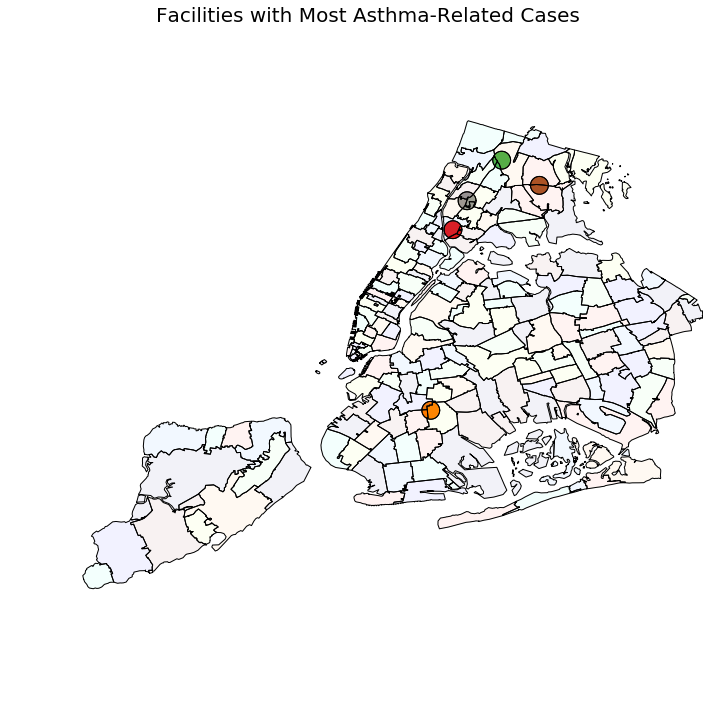

In [13]:
map_series = gp.GeoSeries(with_names['geometry']) # contains points for facility locations
map_gp = GeoDataFrame(zip_fac_df) # contains polygon geometry

points = map_series.buffer(.008) # draw fixed radius around each point 
plt.subplots(figsize = (12,12))
plt.axis('off')
points.plot(alpha = 1)
map_gp.plot(alpha = 0.05)
plt.title('Facilities with Most Asthma-Related Cases', fontsize = 20)
plt.axis('off') # turn off axes because they look weird
#map_gp = GeoDataFrame(zip_fac_df)
#map_gp.plot(column = 'geometry_x')


<h1> Task 2: Geo-referencing the facilities with the zip code highway profile</h1>

In this task, you are to asked to find out which zip code the top 5 facilities found in Task 1 belong to, and how many miles of highway streets are within its proximity. To determine which zip code a facility belongs to, you can either use SQL or GeoPandas. 

<ol>
<li>a list of 5 facilities (like in Task 1.1) but with two additional columns: the ZIP code and the total highway miles belonging to that zip code.</li>
<li> a map (cloropleth) of highway length for all NYC ZIP codes.
</li>

In [14]:
# create new dataframe that includes zipcode and highway length
zip_highways = pd.merge(with_names, zip_geo, on ='zipcode', how = 'outer')
zip_highways = zip_highways[['Facility Name', 'Asthma Occurrences','zipcode', 'highway_length','geometry_y']]
zip_highways = zip_highways.rename(columns = {'geometry_y':'geometry'})
zip_highways.head()

,Facility Name,Asthma Occurrences,zipcode,highway_length,geometry
0,Lincoln Medical & Mental Health Center,1878,10451,7.914185,"(POLYGON ((-73.931681 40.807955, -73.931704 40..."
1,Montefiore Medical Center - Henry & Lucy Moses...,1786,10467,19.172015,"(POLYGON ((-73.863293 40.89529, -73.862875 40...."
2,Kings County Hospital Center,1057,11203,2.212840,"(POLYGON ((-73.942503 40.638965, -73.943986 40..."
3,Jacobi Medical Center,920,10461,18.102258,"(POLYGON ((-73.82612399999999 40.834214, -73.8..."
4,Bronx-Lebanon Hospital Center - Concourse Divi...,890,10457,5.017199,"(POLYGON ((-73.897516 40.856183, -73.896533000..."


In [15]:
zip_highways.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 5 columns):
Facility Name         5 non-null object
Asthma Occurrences    5 non-null float64
zipcode               200 non-null float64
highway_length        200 non-null float64
geometry              200 non-null object
dtypes: float64(3), object(2)
memory usage: 9.4+ KB


(-74.299999999999997,
 -73.699999999999989,
 40.400000000000006,
 41.000000000000007)

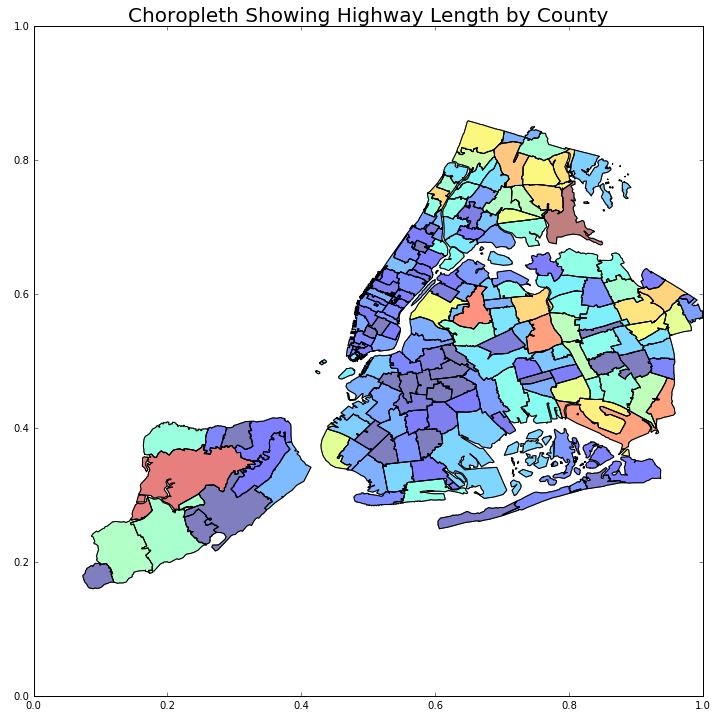

In [16]:
# convert to geodataframe in order to plot on a map

plt.subplots(figsize=(12,12))
zip_highways_gp = GeoDataFrame(zip_highways)
zip_highways_gp.plot(column='highway_length')

plt.title('Choropleth Showing Highway Length by County', fontsize = 20)
plt.axis('off')


# TASK 5:
   Environmental conditions: find the 311 data (see PUI2015_DATA.ipynb). Where and how to select it is described in the Data section and in the hints we give recommendations on how to preprocess the data. Use the 'normalized 311' data (see hints) and return: 
   <ol>
   <li> a dataframe like the one derived in TASK 4 but with an additional column containing this information</li>
   <li> make a choropleth of the normalized 311 calls relevant to environmental conditions per for all ZIP codes in NYC </li> 
    

In [17]:
# loading 311 data from dropbox instead of local file
# takes a few seconds, but it does work
    
urlData = 'https://www.dropbox.com/s/h89wtisfjn3y76i/311_Service_Requests_from_2010_to_Present.csv?dl=1'
data311 = urllib2.urlopen(urlData)
data = pd.read_csv(data311)
    
#service_requests = pd.read_csv('Desktop/python/311_Service_Requests_from_2010_to_Present.csv')
service_requests = data
#print 'There are',len(service_requests['Complaint Type'].unique()),'unique 311 categories present in this dataset'
# print service_requests.head()
service_requests.dropna(inplace = True) # remove entries with NaN zip codes
# rename column headings
service_requests.rename(columns = {'Complaint Type':'complaint_type',
                                   'Incident Zip':'zipcode',
                                   'Created Date':'created_date'},
                                    inplace = True)
print " "
print service_requests.head()

 
             created_date         complaint_type zipcode
0  12/30/2013 11:59:00 PM                  Noise   10034
1  12/30/2013 11:58:49 PM  Street Sign - Missing   11419
3  12/30/2013 11:55:09 PM       Street Condition   11211
4  12/30/2013 11:54:40 PM       Street Condition   11221
5  12/30/2013 11:54:14 PM     Noise - Commercial   10027


In [18]:
# we are going to use the 21 'relevant' categories provided in the hints notebook

validcomplaints = ['UNSANITARY CONDITION','Dirty Conditions', 'Sewer',
                   'Hazardous Material','Construction',
                   'Indoor Air Quality','Indoor Sewage','Air Quality',
                   'HEATING','Industrial Waste','Mold','Asbestos',
                   'Sweeping/Missed-Inadequate','Smoking',
                   'Non-Residential Heat','Lead','Standing Water',
                    'Water Quality','Unsanitary Animal Facility',
                   'PAINT - PLASTER','GENERAL CONSTRUCTION']
#type(validcomplaints)

In [19]:
# create a dataframe of only zipcodes
just_zips = DataFrame({'zip': service_requests['zipcode'].unique()})
#just_zips.head()

In [20]:
# # testing out cleanup function with sample data
# bad_zip = DataFrame({'zip': ['10604-1205', '11109', '10044','14020', '11801', 
#                              'UNKNOWN', '10530', '11507', '07020', '10940', 
#                              '06851', '07094', '11568', '11597', '02453-3483',
#                              '11550','11367-0874', '17106', '07206', '08840']})


In [21]:
# # testing split function
# a = '11597-1-1'
# a.split('-')[0]

In [22]:
#bad_zip.head()

In [23]:
# create a function to clean the zip code data
# removes strings, zip codes that don't begin with 1, and delivery sector (trailing 4 digits)
def cleanup(df):
#     empty list, list will be 1 or nan if below things are true
    list = []
#     for item in the zip code column
    for i in df['zip']:
        # split the string on '-'
        a = i.split('-')[0]
        # nyc zip codes start with 1, so use 1
        if a[0] =='1' and len(a) ==5:
            list.append(a)
        else: 
            list.append(np.nan)
    df['clean_zip'] = list
    new_df = df.dropna()
    return new_df           

In [24]:
# run cleanup function on zipcodes to remove bad data
cleanup(just_zips);

In [25]:
# create dataframe of clean zipcodes - will merge later
df = just_zips
clean_zips = cleanup(df)
del clean_zips['zip']
zipcodes = clean_zips.rename(columns = {'clean_zip':'zipcode'})
zipcodes.head() # use these zip codes from now on
#print 'the number of zipcodes is:',len(zipcodes)

,zipcode
0,10034
1,11419
2,11211
3,11221
4,10027


In [26]:
# create dataframe that includes total and relevant calls per zip code in order to normalize data
service_requests2 = DataFrame(pd.merge(zipcodes,service_requests, on = 'zipcode'))
service_requests2.head()

,zipcode,created_date,complaint_type
0,10034,12/30/2013 11:59:00 PM,Noise
1,10034,12/30/2013 07:47:09 PM,Food Establishment
2,10034,12/30/2013 04:32:00 PM,Street Light Condition
3,10034,12/30/2013 04:17:23 PM,Maintenance or Facility
4,10034,12/30/2013 03:56:54 PM,Boilers


In [27]:
# create a function that looks for 'valid complaints' in complaint type column, then append a boolean (1,0)
# column in order to count occurrences by zip code later on

my_list = []

for i in service_requests2.index:
    if service_requests2['complaint_type'][i] in validcomplaints:
        my_list.append(1)
    else:
        my_list.append(0)

In [28]:
# had some data type issues, but numpy arrays helped get over that
my_alist = np.asarray(my_list)

In [29]:
# create new column that tells us whether a complaint was in a relevant asthma category or not
service_requests2['relevant'] = my_alist[service_requests2.index]
service_requests2.head()

,zipcode,created_date,complaint_type,relevant
0,10034,12/30/2013 11:59:00 PM,Noise,0
1,10034,12/30/2013 07:47:09 PM,Food Establishment,0
2,10034,12/30/2013 04:32:00 PM,Street Light Condition,0
3,10034,12/30/2013 04:17:23 PM,Maintenance or Facility,0
4,10034,12/30/2013 03:56:54 PM,Boilers,0


In [30]:
# aggregate relevant calls by zip code
relevant_count = service_requests2['relevant'].groupby(service_requests2['zipcode']).sum()
relevant_count_df = DataFrame(relevant_count)
relevant_count_df = relevant_count_df.reset_index('zipcode')
relevant_count_df.head() # yay it worked :)

,zipcode,relevant
0,10000,2
1,10001,907
2,10002,2327
3,10003,2295
4,10004,104


In [31]:
# create dataframe with zipcode and total count of 311 complaints - step 1 of normalization
total_count = service_requests2['complaint_type'].groupby(service_requests2['zipcode']).count()
total_count = DataFrame({'total_count':total_count})
total_count = total_count.reset_index('zipcode')
total_count.head()

,zipcode,total_count
0,10000,114
1,10001,6825
2,10002,11259
3,10003,11262
4,10004,1538


In [32]:
# now create a dataframe with zipcode, total count, and relevant count of 311 complaints - step 2 of normalization
final = pd.merge(total_count,relevant_count_df, on = 'zipcode')
#final.head()

In [33]:
# calculate normalized calls by dividng relevant by total - step 3 of normalization
final['normalized'] = final['relevant'] / final['total_count']
#final.head()

In [34]:
# now we will add in highway lengths in order to calculate the regression
#pd.merge(final,zip_highways, on = 'zipcode', how = 'outer')
final['zipcode']=final['zipcode'].astype(float)
#final.info()

In [35]:
final_zip_highway = pd.merge(final,zip_highways, on = 'zipcode')
final_zip_highway = final_zip_highway[['zipcode','total_count','relevant','normalized','highway_length','geometry']]
final_zip_highway.head()

,zipcode,total_count,relevant,normalized,highway_length,geometry
0,10001,6825,907,0.132894,4.853261,"(POLYGON ((-73.999352 40.74733, -74.000399 40...."
1,10002,11259,2327,0.206679,5.163702,"(POLYGON ((-73.97702 40.711649, -73.977141 40...."
2,10003,11262,2295,0.203783,0.000000,"(POLYGON ((-73.981562 40.732643, -73.982022 40..."
3,10004,1538,104,0.067620,8.692550,"(POLYGON ((-74.02213 40.684541, -74.022385 40...."
4,10005,1827,94,0.051450,4.475026,"(POLYGON ((-74.008269 40.707722, -74.008645 40..."


In [36]:
map_final = gp.GeoDataFrame(final_zip_highway)

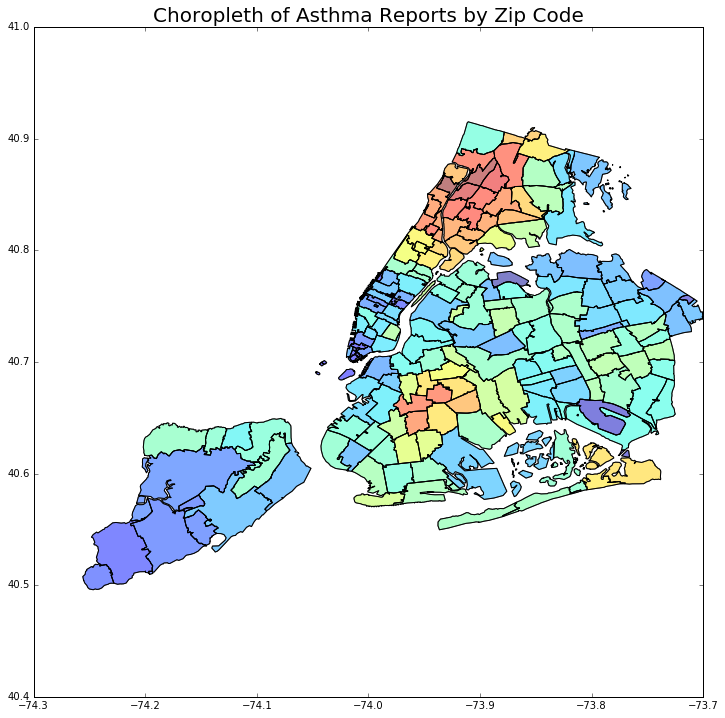

In [37]:
plt.subplots(figsize=(12,12))
plt.title('Choropleth of Asthma Reports by Zip Code', fontsize = 20)
plt.axis('off')
map_final.plot(column = 'normalized')

## Just for fun, let's see how the top five facilities line up with the choropleth



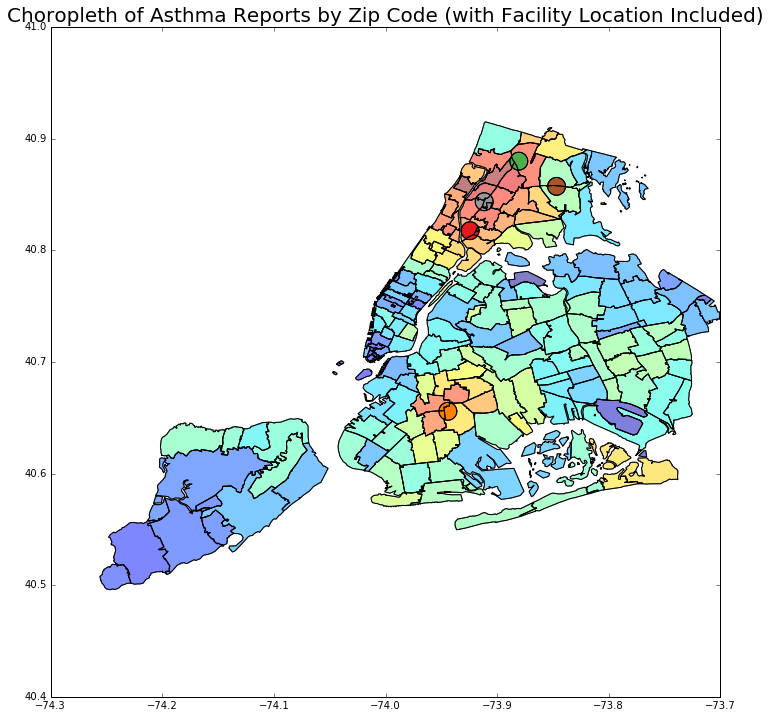

In [38]:
plt.subplots(figsize=(12,12))
plt.title('Choropleth of Asthma Reports by Zip Code (with Facility Location Included)', fontsize = 20)
plt.axis('off')
map_final.plot(column = 'normalized')
points.plot(alpha = 1)


### Looks like theres a correlation between the top five asthma locations and the amount of highways in a county

# TASK 6:
  create a regression model for the 5 zip codes that includes at least 2 of the variables (fewer than 2 will not allow a passing grade): 
  highway length in the zip code, exposure to violent crimes in that zip code, 
  access to green spaces in that zip code, 311-normalized calls in that zip code. 
        
  Report the statistics for your model and assess how well it describes the dependent variable.
    

In [39]:
# now create a new dataframe that merges the top 5 from task 1 with the normalized data from task 5
reg_df = pd.merge(with_names,final_zip_highway, on = 'zipcode', how = 'inner')
reg_df.head()

,Facility Name,Asthma Occurrences,zipcode,geometry_x,total_count,relevant,normalized,highway_length,geometry_y
0,Lincoln Medical & Mental Health Center,1878,10451,POINT (-73.92421 40.817661),8212,3924,0.477837,7.914185,"(POLYGON ((-73.931681 40.807955, -73.931704 40..."
1,Montefiore Medical Center - Henry & Lucy Moses...,1786,10467,POINT (-73.880562 40.879951),23569,12384,0.525436,19.172015,"(POLYGON ((-73.863293 40.89529, -73.862875 40...."
2,Kings County Hospital Center,1057,11203,POINT (-73.94409899999999 40.655823),16883,6946,0.411420,2.212840,"(POLYGON ((-73.942503 40.638965, -73.943986 40..."
3,Jacobi Medical Center,920,10461,POINT (-73.84674099999999 40.857388),9621,2918,0.303295,18.102258,"(POLYGON ((-73.82612399999999 40.834214, -73.8..."
4,Bronx-Lebanon Hospital Center - Concourse Divi...,890,10457,POINT (-73.911545 40.843609),18617,9907,0.532148,5.017199,"(POLYGON ((-73.897516 40.856183, -73.896533000..."


In [40]:
reg_df = reg_df.rename(columns = {'Asthma Occurrences':'asthma'})

In [41]:
mod = smf.ols(formula = 'asthma ~ normalized + highway_length', data = reg_df).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                 asthma   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                 -0.286
Method:                 Least Squares   F-statistic:                    0.5550
Date:                Tue, 19 Jan 2016   Prob (F-statistic):              0.643
Time:                        16:04:30   Log-Likelihood:                -36.356
No. Observations:                   5   AIC:                             78.71
Df Residuals:                       2   BIC:                             77.54
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept       -206.3139   1490.901     -0.

/usr/local/lib/python2.7/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))


In [42]:
mod.params

Intercept         -206.313945
normalized        2780.642921
highway_length      24.910008
dtype: float64

In [43]:
# # use the params to create the metric, starting with the value for the normalized column
# x = final_zip_highway
# n_list = []
# for i in range(len(x)):
#     norm = final_zip_highway['normalized'][i]*mod.params[1]
#     n_list.append(norm)   

# n_list = DataFrame(n_list)
# n_list = n_list.rename(columns = {0:'norm_val'})
# #n_list.head()

In [44]:
# # then do the same thing for the highway length
# y = final_zip_highway
# r_list = []
# for i in range(len(y)):
#     high = final_zip_highway['highway_length'][i]*mod.params[2]
#     r_list.append(high)

# r_list = DataFrame(r_list)
# r_list = r_list.rename(columns = {0:'highway_val'})
# #r_list.head()

In [45]:
# create new df columns to calculate metric
final_zip_highway['norm_val'] = final_zip_highway['normalized']*mod.params[1]
final_zip_highway['highway_val'] = final_zip_highway['highway_length']*mod.params[2]

# assign them to variables because typing them out is a lot of work
a = final_zip_highway['norm_val']
b = final_zip_highway['highway_val']

# metric calculation below
final_zip_highway['metric'] = a+b
final_zip_highway.head()

,zipcode,total_count,relevant,normalized,highway_length,geometry,norm_val,highway_val,metric
0,10001,6825,907,0.132894,4.853261,"(POLYGON ((-73.999352 40.74733, -74.000399 40....",369.530129,120.894767,490.424896
1,10002,11259,2327,0.206679,5.163702,"(POLYGON ((-73.97702 40.711649, -73.977141 40....",574.700780,128.627866,703.328645
2,10003,11262,2295,0.203783,0.000000,"(POLYGON ((-73.981562 40.732643, -73.982022 40...",566.646733,0.000000,566.646733
3,10004,1538,104,0.067620,8.692550,"(POLYGON ((-74.02213 40.684541, -74.022385 40....",188.027870,216.531491,404.559360
4,10005,1827,94,0.051450,4.475026,"(POLYGON ((-74.008269 40.707722, -74.008645 40...",143.065372,111.472928,254.538300


### Regression Results Interpretation

As we can see from the OLS regression results, 311 data and the length of highways for a given zip code is insufficient for explaining asthma attacks. The R-squared value of 0.357 means that the model covers around 36& of the variance, but the high p-values (considerably greater than 0.005) tell us that this coverage is not statistcally significant. Additionally, using only five values in the sample is hardly enough to draw any meaningful inference from the results. Running the same model with the complete set of zip codes may yield better results.

In [46]:
# calculate metric
# uses metric presented in hints notebook
#reg_df.params

# TASK 7:
   Use the elements of this model to cluster NYC zip codes by asthma risk. Your distance metric can be built on the result of the regression. See Hints file if you need help on this task
   
   The result will be a map of the clusters.

below is an example of a map derived by clustering from a model as the one you are required to make. This is just an example though: remember that  your model will be different, so the map will be different!)

In [47]:
# import sklearn modules
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random

In [48]:
# clean up regression dataframe for use in k-means
cluster_df = final_zip_highway[['zipcode','metric']]

Using 2 clusters, the silhouette score is 0.585221855689.
Using 3 clusters, the silhouette score is 0.640995271395.
Using 4 clusters, the silhouette score is 0.494290159538.
Using 5 clusters, the silhouette score is 0.438990013054.
Using 6 clusters, the silhouette score is 0.422502209366.
Using 7 clusters, the silhouette score is 0.393078270848.
Using 8 clusters, the silhouette score is 0.405772893103.
Using 9 clusters, the silhouette score is 0.413282016257.


(0.2, 0.8)

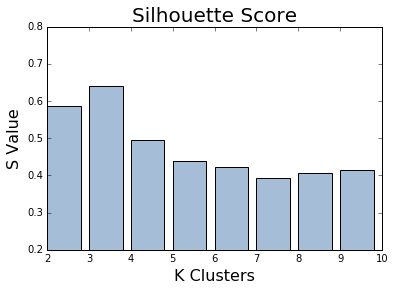

In [49]:
# calculate silhouette score to determine appropriate number of clusters
# this code was pulled from one of the ADS lecture notebooks, which lets me print out the list of clusters/scores

s = np.zeros(8)
for k in range(0, 8):
    est = KMeans(n_clusters = k+2, n_init = 100)
    est.fit(cluster_df)
    s[k] = silhouette_score(cluster_df, est.labels_)
    print('Using {0} clusters, the silhouette score is {1}.'.format(k+2, s[k])) 
    
plt.figure(figsize=(6, 4))
plt.bar(range(2, 10), s, color = '#A6BDD7')
plt.xlabel('K Clusters', fontsize = 16)
plt.ylabel('S Value', fontsize = 16)
plt.title('Silhouette Score', fontsize = 20)
plt.ylim(.2, .8)

### The silhouette score peaks at 3 clusters, so that's what we should use for K-Means

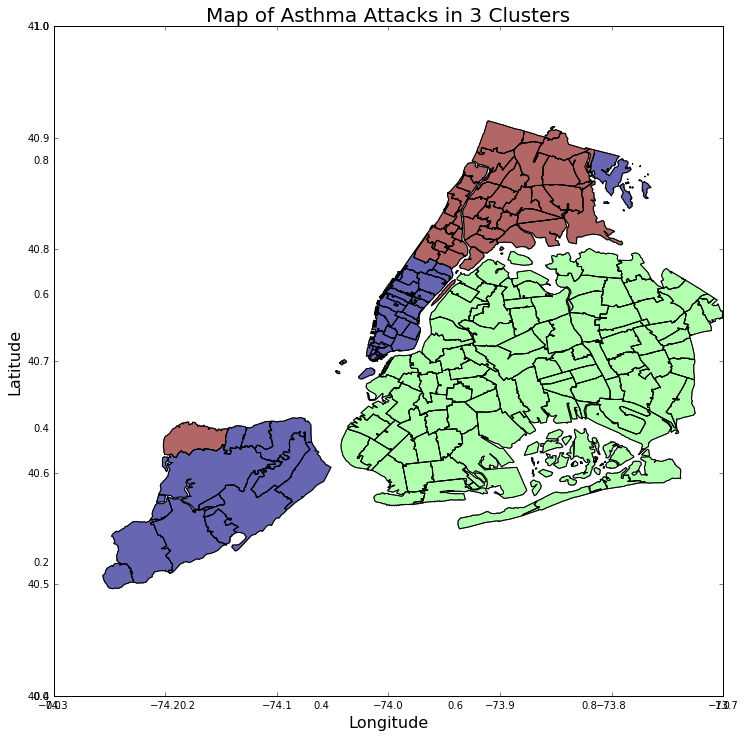

In [50]:
# calculate k-means clusters
# this code is heavily based on the HW10 code

k = 3 # use 3 cluster

kmeans = KMeans(k, n_init = 100)
#kmeans.fit(final)
kmeans.fit(cluster_df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
cluster_frame = pd.DataFrame({'zip_code':final_zip_highway['zipcode'],
                              'cluster_id':kmeans.labels_,
                             'geometry': final_zip_highway['geometry']})
# cluster_frame[50:100] # this line shows that the k-means was successful. three different cluster_ids present
dat = GeoDataFrame(cluster_frame)
plt.subplots(figsize = (12,12))
#dat.plot(column='zip_code',alpha=0.6)
dat.plot(column='cluster_id', alpha = 0.6)
plt.title('Map of Asthma Attacks in 3 Clusters', fontsize = 20)
plt.xlabel('Longitude', fontsize = 16)
plt.ylabel('Latitude', fontsize = 16)
plt.grid('off')

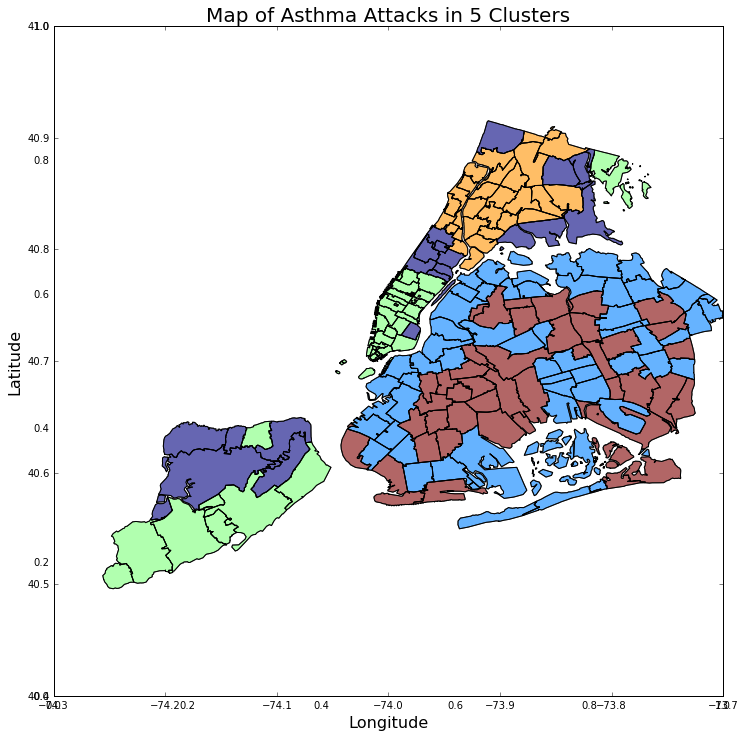

In [51]:
# calculate k-means clusters
# this code is heavily based on the HW10 code

k = 5 # trying it with five to see if it makes more sense than the map with three

kmeans = KMeans(k, n_init = 100)
#kmeans.fit(final)
kmeans.fit(cluster_df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
cluster_frame = pd.DataFrame({'zip_code':final_zip_highway['zipcode'],
                              'cluster_id':kmeans.labels_,
                             'geometry': final_zip_highway['geometry']})
# cluster_frame[50:100] # this line shows that the k-means was successful. three different cluster_ids present
dat = GeoDataFrame(cluster_frame)
plt.subplots(figsize = (12,12))
#dat.plot(column='zip_code',alpha=0.6)
dat.plot(column='cluster_id', alpha = 0.6)
plt.title('Map of Asthma Attacks in 5 Clusters', fontsize = 20)
plt.xlabel('Longitude', fontsize = 16)
plt.ylabel('Latitude', fontsize = 16)
plt.grid('off')

## DISCUSSION

This exercise attempted to find factors that contributed to reported asthma rates in zip codes throughout New York City using certain categories of 311 data. Using a combination of spatial analysis, linear regression, and clustering, I was able to draw some insights to answer this question, but I would hardly call them conclusive.

Comparing the two choropleth graphs showed some interesting results. The first graph, depicting a scale of highway length by zip code, lets us see that in Brooklyn, one might argue that the number of streets has an impact on reported asthma rates because the two high density areas mostly overla (large values for 311 calls and highway lengths both appear in central Brooklyn). However, this visual correlation does not extend much further, as the regression results show that highway length doesn't really have an impact on asthma rates. While these results may improve with a larger sample size (instead of just the five zip codes included in the model), adding additional features would likely improve the result as well. Specifically, using traffic volume data to either replace or complement the highway length data would let us get closer to the actual cause, as it is not reasonable to say that highways are the cause of asthma. The cause of the asthma likely comes from the *cars* on the highway and the emissions coming from their exhaust systems. 

The clustering results are a bit more conclusive. Using the silhouette score, I determined that three clusters was the correct number to use for the K-means analysis. However, the resulting map doesn't help very much, as it merely splits Staten Island and Manhattan/Bronx up while leaving Brooklyn and Queens in one column. I decided to disregard the silhouette score and run it with five clusters instead. The analysis with five clusters appears to align better with the choropleth map from Task 5, with the green and reddish-brown clusters form K-means appearing in the same general areas as the orange and red areas in the choropleth.


